In [3]:
# Import libraries
import glob
import pandas as pd
import geopandas as gpd

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
import sys
import matplotlib
import scienceplots
import matplotlib.colors as mcolors
from matplotlib.offsetbox import AnchoredText
plt.style.use('science')

%matplotlib inline

import libgeohash as gh
from shapely.geometry.polygon import Polygon
from shapely.geometry import Point

import contextily as cx
import xyzservices.providers as xyz

In [4]:
def getPolygon (geoHash):
    auxGeoHash = gh.bbox(geoHash)
    p = Polygon([
    Point([auxGeoHash['w'],auxGeoHash['n']]),
    Point([auxGeoHash['e'],auxGeoHash['n']]),
    Point([auxGeoHash['e'],auxGeoHash['s']]),
    Point([auxGeoHash['w'],auxGeoHash['s']])
    ])
    return p
    #return Polygon(gh.bbox(geoHash, coordinates = True))

{'n': 22.8076171875, 's': 22.763671875, 'w': 75.8935546875, 'e': 75.9375}


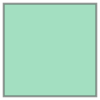

In [5]:
auxGeoHash = gh.bbox("tsjcx")
print (auxGeoHash)
#w,n w,s e,n e,s

p = Polygon([
Point([auxGeoHash['w'],auxGeoHash['n']]),
Point([auxGeoHash['e'],auxGeoHash['n']]),
Point([auxGeoHash['e'],auxGeoHash['s']]),
Point([auxGeoHash['w'],auxGeoHash['s']])
])
#[Point([auxGeoHash[''],auxGeoHash[''])]
p

# India

In [6]:
country_code = 'IN'
year = '2020'
agg_level = '5'

In [7]:
# Get CSV files list from a folder
path = "../data/popDensity/{}/{}".format(country_code,year)
csv_files = glob.glob(path + "/IN_daily_agg5_hour_*.csv_kanonnimized.csv")

# Read each CSV file into DataFrame
# This creates a list of dataframes
df_list = (pd.read_csv(file) for file in csv_files)

# Concatenate all DataFrames
big_df   = pd.concat(df_list, ignore_index=True)

In [8]:
big_df.to_csv(path+"/{}_daily_3h_popDensity_agg{}_{}.csv".format(country_code,agg_level,year), index=False )
print ("Saved on: " + path+"/{}_daily_3h_popDensity_agg{}_{}.csv".format(country_code,agg_level,year))
big_df.head()

Saved on: ../data/popDensity/IN/2020/IN_daily_3h_popDensity_agg5_2020.csv


,popDensity,grt,day,month,geohash5
0,30,0,1,4,tdqgf
1,20,0,1,4,wh9hx
2,13,0,1,4,tsjcx
3,55,0,1,4,ttnfb
4,30,0,1,4,tgcbd


In [9]:
grouped = big_df[["geohash5","popDensity"]].groupby('geohash5')
sum_popDensity = grouped.sum().reset_index()
sum_popDensity['popDensity'] = sum_popDensity['popDensity'].astype(int)

print(average_popDensity)

sum_popDensity.to_csv(path+"/{}_popDensity_agg{}_{}_sum.txt".format(country_code,agg_level,year), index=False, sep="\t" )
sum_popDensity.to_csv(path+"/{}_popDensity_agg{}_{}_sum.csv".format(country_code,agg_level,year), index=False )
print ("Saved on: " + path+"/{}_popDensity_agg{}_{}_sum.csv".format(country_code,agg_level,year))


NameError: name 'average_popDensity' is not defined

## Plot

In [10]:
grouped = big_df[["geohash5","popDensity"]].groupby('geohash5')
average_popDensity = grouped.mean().reset_index()
average_popDensity['popDensity'] = average_popDensity['popDensity'].astype(int)

average_popDensity.to_csv(path+"/{}_popDensity_agg{}_{}_avg.txt".format(country_code,agg_level,year), index=False, sep="\t" )
average_popDensity.to_csv(path+"/{}_popDensity_agg{}_{}_avg.csv".format(country_code,agg_level,year), index=False )
print ("Saved on: " + path+"/{}_popDensity_agg{}_{}_avg.csv".format(country_code,agg_level,year))


Saved on: ../data/popDensity/IN/2020/IN_popDensity_agg5_2020_avg.csv


In [11]:
average_popDensity['geometry'] = average_popDensity['geohash5'].apply(getPolygon)
average_popDensity_gdf = gpd.GeoDataFrame(
    average_popDensity, geometry=average_popDensity.geometry, crs="EPSG:4326"
)
average_popDensity_gdf.head()

,geohash5,popDensity,geometry
0,t9qxx,12,"POLYGON ((76.94824 8.39355, 76.99219 8.39355, ..."
1,t9qxz,13,"POLYGON ((76.94824 8.43750, 76.99219 8.43750, ..."
2,t9qyr,10,"POLYGON ((77.29980 8.17383, 77.34375 8.17383, ..."
3,t9qyt,10,"POLYGON ((77.21191 8.21777, 77.25586 8.21777, ..."
4,t9qyu,10,"POLYGON ((77.16797 8.26172, 77.21191 8.26172, ..."


In [12]:
average_popDensity_gdf[['popDensity']].describe()

,popDensity
count,10639.000000
mean,14.923865
std,17.853913
min,10.000000
25%,10.000000
50%,11.000000
75%,12.000000
max,313.000000


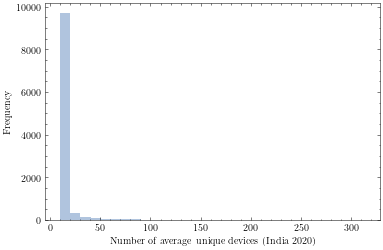

In [13]:
fig, ax = plt.subplots( )
n_bins = 30
ax.hist(average_popDensity_gdf[['popDensity']].values, bins=n_bins, color=mcolors.CSS4_COLORS['lightsteelblue'])
ax.set_xlabel('Number of average unique devices (India 2020)') 
ax.set_ylabel('Frequency') 
plt.savefig("../outputs/IN_avg_3h_2020.png")

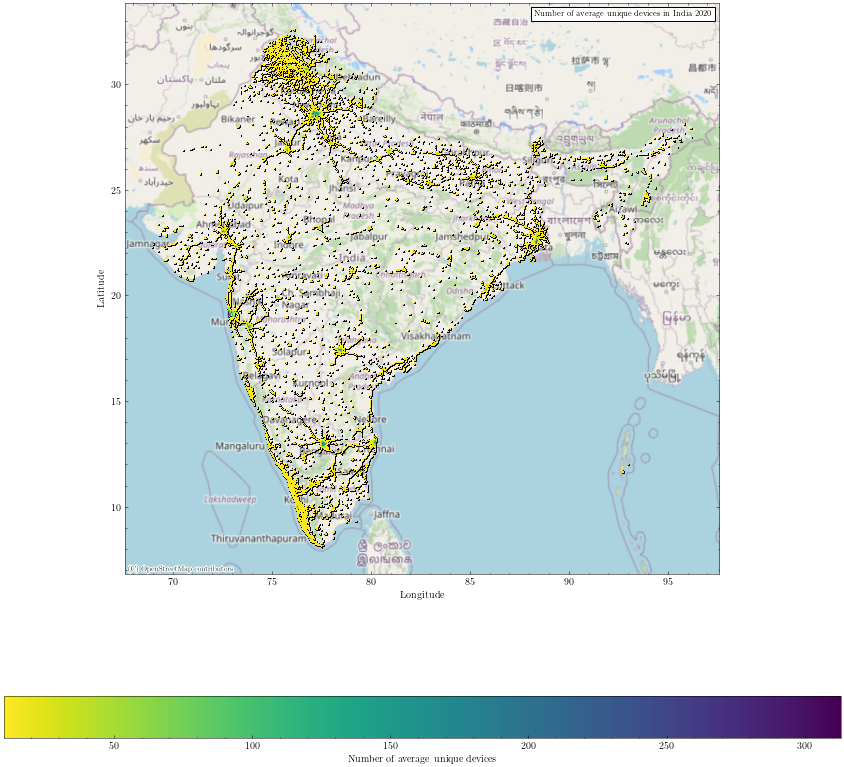

In [26]:
ax = average_popDensity_gdf.plot(color="red",edgecolor="black",markersize=50,figsize=(15, 15))
cx.add_basemap(ax, crs=average_popDensity_gdf.crs.to_string(), source=cx.providers.OpenStreetMap.Mapnik)
ax.set_xlabel('Longitude') 
ax.set_ylabel('Latitude') 


average_popDensity_gdf.plot(
    ax=ax,
    cmap='viridis_r',
    column="popDensity",
    legend=True,
    legend_kwds={"label": "Number of average unique devices", "orientation": "horizontal"},
    
)
#plt.subplots_adjust(bottom=0.5)
text = AnchoredText('Number of average unique devices in India 2020 ',loc=1, prop={'size': 8}, frameon=True)
ax.add_artist(text)



plt.savefig("../outputs/map_IN_avg_3h_2020.png",bbox_inches='tight',dpi=300)